# Generative AI

One of the major breakthroughs in AI in the past decade is in the area of _generative_ AI models. Large language models (LLMs) such as ChatGPT - by some considered synonimous to "AI" - are in fact generative models.These models are currently able to generate text, images, and video, to an increasingly accurate and realistic level. Intriguingly, it is not yet clear to what extent the generation of for example text implies "understanding" of the topics on the part of the network. Although the network architecture, training procedure, and data input strategy are developed and known by the human designers, our insight into how trained generative networks actually perform the task is still very limited.

This notebook is a brief introduction to generative AI models and some of the basic techniques. It draws from the material in “Deep learning: Foundations and concepts”, by Bishop, C. M., & Bishop, H. (2023), and other original works from the literature.

## Discriminatory vs. generative models

Initial models treated in courses on machine learning for AI typically involve _discriminatory_ models. An example is an artificial feedforward neural network that has to learn a function $y = f(\mathbf{x})$ with supervised learning, based on training pairs $(\mathbf{x}_i, {y}^{*}_i)$. Such models essentially learn the probability distribution $P(y|x)$.

Generative models, on the other hand, learn to generate new samples $\mathbf{x}$ that resemble the training data $\{\mathbf{x}_i\}$. In other words, they try to represent $P(x)$. The aim is very similar to modeling in science, i.e., the aim for generative models is to represent the underlying processes that give rise to the data. Eventually, modelling these processes will also useful for predicting variables of interest. One can think of how weather forecasts usually depend on various weather models, and how it would compare to purely discriminatory models, trained with samples of measurements and targets (like predicted temperature or other weather conditions).

The desired benefits of generative models are:

* They can capture causal relationships that will generalize better to unseen situations.
* They lead to useful intermediate representations that can serve downstream (discriminatory) tasks.
* Since they do not need labels, they expand the data on which can be learned. The size of the training data is very important for the performance of deep neural networks.
* Some models permit for the use of domain knowledge to constrain the generation process, improving their accuracy and generalization capability.

Generative AI has been studied since at least the early 1980s, e.g., with “Boltzmann” machines, but it has blossomed with the arrival of deep learning.

We will treat the following three approaches:
- Variational Auto-Encoders (VAEs)
- Generative Adversarial Networks (GANs)
- Diffusion models

## Variational Auto-Encoder (VAE)

One of the most well-known generative models is the Variational Auto-Encoder (VAE). 


### Studying a fully convolutional neural network (FCNN)
This model is based on fully convolutional auto encoders like the neural network below (so this is not a VAE yet). This specific FCNN transforms an input image of a number from the MNIST dataset $\mathbf{x}$ via a low-dimensional latent space $\mathbf{z}$ to a reconstruction of itself, $\mathbf{\hat{x}}$. The goal of such an auto-encoder is to train a neural network to compress the information in the image to the low-dimensional latent space $\mathbf{z}$.

<IMG SRC="FCNN_1.png"></IMG>

In the notebook on deep neural networks, we trained such an FCNN. Let us now investigate its latent space a bit. We should first load the MNIST data set and load the trained network, which is done by the code below. 

Although the file `FCNN.py` already contains the FCNN class definition, we reproduce it below, so that you can see how: 
1. In the forward function, we store the latent space in a class member variable, `self.latent`. In this way, we can retrieve the latent space after running the network. Note that in contrast, all the `tmp` values are lost.
2. The class contains a function `decoder` that only runs the decoding part of the network. We can pass a latent space vector to it, and it will generate an image.

In [11]:
import AE
import torch
from torch import nn

# Get the training data:
training_data, test_data, training_x, training_y, training_labels, test_x, test_y, test_labels = AE.load_training_data()


class FCNN(nn.Module):
    def __init__(self, n_hidden = 25):
        super(FCNN, self).__init__()
        self.flatten = nn.Flatten()
        in_channel = 1
        out_channel = 16
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=5, padding ='same') # bias = False
        self.act1 = nn.ReLU(inplace= True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear2 = nn.Linear(3136,n_hidden)
        self.linear5 = nn.Linear(n_hidden, 2304)
        self.act5 = nn.ReLU(inplace= True)
        self.resh = nn.Unflatten(1, (16, 12, 12))
        self.deconv = nn.ConvTranspose2d(out_channel, in_channel, kernel_size=6, stride = 2, padding_mode ='zeros')
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):

        # fully convolutional pipeline:
        
        # encoder:
        self.feature_maps = self.conv1(x)
        tmp = self.act1(self.feature_maps)
        tmp = self.maxpool1(tmp)
        tmp = torch.flatten(tmp, 1, -1)
        z = self.linear2(tmp)
        
        # store the latent space in a class member variable ("self.")
        # so that we can retrieve it after running the model.
        self.latent = z
        
        # decoder:
        tmp = self.linear5(self.latent)
        tmp = self.act5(tmp)
        tmp = torch.flatten(tmp, 1, -1)
        tmp = self.resh(tmp)
        logits = self.deconv(tmp)
        logits = self.sigmoid(logits)

        return logits

    def decoder(self, latent):

        # run only the decoding part of the network:
        tmp = self.linear5(latent)
        tmp = self.act5(tmp)
        tmp = torch.flatten(tmp, 1, -1)
        tmp = self.resh(tmp)
        logits = self.deconv(tmp)
        logits = self.sigmoid(logits)

        return logits

# Create the FCNN model:
n_hidden = 25
model = FCNN(n_hidden=n_hidden)

# load the trained model:
model.load_state_dict(torch.load("fcnn_model.pth"))


<All keys matched successfully>

Interestingly, one can use the decoder part of the network as a generative model. For example, we can take a vector of the same length as the latent space, and set each element to a random normally distributed number $\sim \mathcal{N}(0,1)$. Run the following cell to see the result:

C:\Users\gdecroon\AppData\Local\Temp\ipykernel_47268\1464040483.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,sam+1)


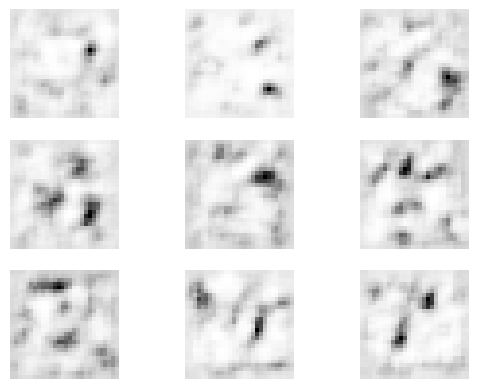

In [12]:
from matplotlib import pyplot as plt

n_samples = 9
plt.figure()
plt.title('Random Samples from Latent Space')
for sam in range(n_samples):
    latent = torch.randn((1,n_hidden))
    reconstr = model.decoder(latent)
    plt.subplot(3,3,sam+1)
    plt.imshow(1-reconstr.detach().cpu().numpy().reshape((28,28)),  cmap='gray')
    plt.axis('off')
plt.show()

As you can see, it doesn't really generate any numbers... 

We can also have a look at how the data is distributed in the latent space. The problem is, however, that it is 25-dimensional. This is hard to interpret for us humans. A common way to deal with this is to employ a dimensionality reduction technique that transforms the data to a lower-dimensional space, while trying to retain as good as possible the relations between the data points in the higher-dimensional space. We use t-SNE to this end [1]. Please run the cell below: 

Running on the whole data set.
Performing t-SNE


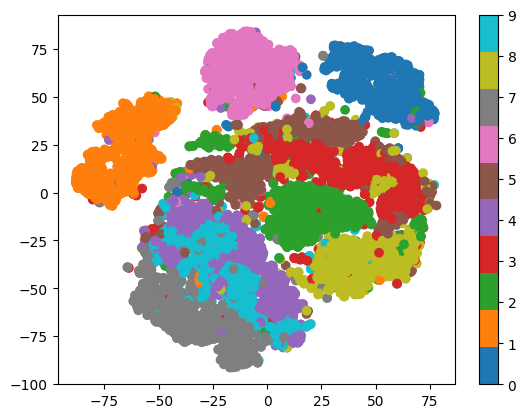

In [13]:
from sklearn.manifold import TSNE 
import numpy as np

# run the model on all training samples, storing the latent space activations:
print('Running on the whole data set.')
step = 5 # ok, not the whole data set : )
latents = torch.zeros((len(training_x)//step, n_hidden))
labels = np.zeros((len(training_x)//step,))
with torch.no_grad():
    for i in range(0,len(training_x),step):
        X = training_x[i]
        X = X.reshape((1,1,28,28))
        _ = model(X)
        latents[i//step] = model.latent
        labels[i//step] = training_labels[i]

# run t-SNE on the latent space:

# Move to CPU and convert to numpy
latent_np = latents.detach().cpu().numpy()

print('Performing t-SNE')
# Run t-SNE (reduce to 2D for visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_np)

# plot the 2d representation of the latent space: 
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="tab10")
plt.colorbar()
plt.show()

As you can see, there is quite some mixing between the classes in the latent space. For example, digit `5` is quite mixed with other digits, such as `3` and `2`. 

### Explanation of the VAE
A variational auto-encoder is also a fully convolutional neural network, but now the latent space represents each image not as a point but as a probability distribution. In most cases, a normal distribution is used. Consequently, the encoder transforms the input image to a latent space $\mathbf{z}$ that consists of two parts: a vector representing the mean of the distribution, $\mathbf{z_{\mu}}$ and a vector representing the standard deviation of the distribution, $\mathbf{z_{\sigma}}$.

When an input image is passed into the network, the encoding part first transforms the image into the latent space vector. In our case, the dimensionality of this vector will be 50, so that both the mean and standard deviation will have dimensionality 25. This means that the data will be projected to the same dimensionality as for the normal auto-encoder studied above. 

Then, a _sample_ is taken from the normal distribution, $\sim \mathcal{N}(\mathbf{z_{\mu}},\mathbf{z_{\sigma}})$. This sample, which has 25 dimensions in our case, will then be decoded to a reconstruction of the input image. The structure of the VAE can be seen below.

<IMG SRC="FCNN_2.png"></IMG>

**Mathematical background**

As a generative model, the VAE tries to learn $P(\mathbf{x})$. This distribution can be reformulated and approximated as follows:

$P(x)= \int P(x|z)P(z) dz = \int P(x|z)P(z) \frac{q(z|x)}{q(z|x)} dz$ 

$= \mathbb{E}_q\left[ \frac{P(x|z)P(z)}{q(z|x)} \right] \approx \sum_{i=1}^N \frac{P(x|z_i)P(z_i)}{q(z_i|x)}$.

The important thing here is that the probability distribution is represented by three parts:
1. <span style="color:blue">$q(z_i|x)$</span>: The probability distribution of the latent space given an input. This is modelled by the encoding part of the network. 
2. <span style="color:green">$P(z_i)$</span>: The probability distribution of the latent space. With a VAE, we want this distribution to be close to a desired prior distribution, such as a unit normal distribution.
3. <span style="color:orange">$P(x|z_i)$</span>: The probability distribution of the reconstruction, given a latent space vector. This is modeled by the decoding part of the network.

The training optimizes the network parameters $\Theta$, of the encoder $\Theta_e$ and decoder $\Theta_d$:

$\mathrm{max}_{\Theta} P(x; \Theta) = \mathrm{max}_{\Theta} \left( \mathrm{log}\left(  \mathbb{E}_q\left[ \frac{P(x|z,\Theta_d) P(z)}{ q(z|x,\Theta_e)} \right] \right) \right)$

By Jensen's inequality:

$\mathrm{log}\left(  \mathbb{E}_q\left[ \frac{P(x|z,\Theta_d) P(z)}{ q(z|x,\Theta_e)} \right] \right) \geq \mathbb{E}_q\left[ \mathrm{log}\left(   \frac{P(x|z,\Theta_d) P(z)}{ q(z|x,\Theta_e)}  \right) \right] = \mathrm{ELBO}[\Theta]$, 

where ELBO stands for the evidence lower bound. This can be written as:

 $\mathrm{ELBO}[\Theta] = \sum_{i=1}^N \mathbb{E}_q [ P(x|z, \Theta_d) ] - D_{KL} \left( q(z|x, \Theta_e) \,\|\, P(z) \right)$
 
 , where the expectation of $x$ given $z$ captures the probability of the reconstruction, and $D_{KL}$ is the Kullback-Leibler divergence between the latent space distribution as learned by the network ($q$) and the desired prior distribution $P(z)$. 
 
**Loss functions**

Maximizing the ELBO is done by minimizing a loss function, which consists of two parts. The first part captures $P(x|z)$, and is minimal when the input image is perfectly reconstructed. We will use the Mean Square Error (MSE) for this:

$\mathcal{L}_{\mathrm{MSE}} = \frac{1}{M} \sum_{j=1}^{M} (x_j - \hat{x}_j)^2$,

where $j$ indexes the pixels in the image, and $M$ is the total number of pixels in the image. 

The second part captures the Kullback-Leibler divergence between the empirical distribution $q(z|x)$ and the desired prior distribution. Typically, the desired prior distribution is a zero-mean, unit standard deviation, normal distribution. This leads to the following loss function:

$\mathcal{L}_{\mathrm{KL}} = \sum_{k=1}^D \frac{1}{2} \left( \mathrm{log}( \frac{1}{\sigma_k}^2 ) + \sigma_k^2 + \mu_k^2 - 1 \right)$

, where $D$ is the dimensionality of the latent space $\mathbf{z}$, in our case $D=25$. 

The loss function that is minimized in training is:

$\mathcal{L} = \mathcal{L}_{\mathrm{MSE}} + \beta * \mathcal{L}_{\mathrm{KL}}$,

where $\beta$ is a Lagrangian multiplier that balances the two losses, which may have quite a different magnitude.


**<span style="color:red">Exercise 1: Implementing and training the VAE</span>**

You will now adapt the `FCNN` class to make it a variational auto-encoder. The new class is called `FCNN_VAE`, and you can find it in the cell below. 

1. Implement the missing code in the `forward` function. The code should take the 50-dimensional latent space and generate a 25-dimensional sample that serves as input to the decoder. Use the same code for the `decode` function. You will validate your implementation when training it in the next part of the exercise.

Hints & tips:
- It is bad programming practice to use "magical" numbers such as 25 or 50. Make sure that the code will also work when changing `n_hidden` to, e.g., 100, by making use of the `n_hidden` variable name.
- In order to allow for backpropagation to work, make use of the "reparametrization trick": Draw a random number according to a zero-mean, unit-standard-deviation distribution, and multiply this with the standard deviation predicted by the encoding network. Then add the mean predicted by the encoding network.


In [5]:
import torch
from torch import nn
import VAE

class FCNN_VAE(nn.Module):
    def __init__(self, n_hidden = 50):
        super(FCNN_VAE, self).__init__()
        self.flatten = nn.Flatten()
        
        in_channel = 1
        out_channel = 16
        self.n_hidden = n_hidden
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=5, padding ='same') # bias = False
        self.act1 = nn.ReLU(inplace= True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear2 = nn.Linear(3136,n_hidden)
        self.linear5 = nn.Linear(n_hidden//2, 2304)
        self.act5 = nn.ReLU(inplace= True)
        self.resh = nn.Unflatten(1, (16, 12, 12))
        self.deconv = nn.ConvTranspose2d(out_channel, in_channel, kernel_size=6, stride = 2, padding_mode ='zeros')
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):

        # convolutional pipeline:
        
        # encoder:
        self.feature_maps = self.conv1(x)
        tmp = self.act1(self.feature_maps)
        tmp = self.maxpool1(tmp)
        tmp = torch.flatten(tmp, 1, -1)
        tmp = self.linear2(tmp)

        # latent space:
        self.latent = tmp
        
        # *****************************
        # TODO: fill in your code here:
        # *****************************
        
        #...
        sample = self.mu + eps * std

        # decoder:
        tmp = self.linear5(sample)
        tmp = self.act5(tmp)
        tmp = torch.flatten(tmp, 1, -1)
        tmp = self.resh(tmp)
        logits = self.deconv(tmp)
        logits = self.sigmoid(logits)

        return logits

    def decoder(self, latent):

        # *****************************
        # TODO: fill in your code here:
        # *****************************
        # ...
        sample = self.mu + eps * std

        # decode the sample:
        tmp = self.linear5(sample)
        tmp = self.act5(tmp)
        tmp = torch.flatten(tmp, 1, -1)
        tmp = self.resh(tmp)
        logits = self.deconv(tmp)
        logits = self.sigmoid(logits)

        return logits

2. Implement the loss functions that will be used in the training loop, by first extracting the mean and standard deviation, and then implementing the losses. Weigh the KL divergence with $\beta$.


In [2]:
def train_loop(training_x, training_y, batch_size, model, loss_fn, optimizer):
    
    size = len(training_x)
    
    # shuffle the indices to get random batches:
    inds = np.random.permutation(size)
    
    num_batches = size // batch_size

    rec_loss = np.zeros((num_batches,))
    kl_div_loss = np.zeros((num_batches,))

    for batch in range(num_batches):
        
        # Get the batch samples:
        inds_batch = inds[batch*batch_size:(batch+1)*batch_size]
        X = training_x[inds_batch]
        y = training_y[inds_batch]
        
        # Compute prediction and loss
        pred = model(X)
        latent = model.latent
        
        # *********************************************
        # TODO: extract the mean and standard deviation
        # *********************************************
        
        # ...

        # *************************
        # TODO: Implement the loss:
        # *************************
        
        # reconstruction loss:
        reconstruction_loss = loss_fn(pred, y)
        # add the KL divergence loss:
        # ...
       
        # combine and store losses:
        loss = ...
        rec_loss[batch] = reconstruction_loss.item()
        kl_div_loss[batch] = kl_div.item()

        # Backpropagation
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return np.mean(rec_loss), np.mean(kl_div_loss)

3. Test your implementations by training the FCNN_VAE model. The reconstructions should resemble the inputs. A reconstruction loss of $\leq 0.03$ is good. Moreover, the KL divergence loss should be limited, e.g., $\leq 500$. Debug your code and tune your parameters, until you obtain a sufficient performance. Always also run the cell under exercise element 4, since this will show you the reconstructions for a number of samples from the training set. This will give you an intuition as to what reconstrcution loss is good enough. 

In [3]:
import numpy as np

# load the data:
training_data, test_data, training_x, training_y, training_labels, test_x, test_y, test_labels = VAE.load_training_data()

# Create an FCNN:
n_hidden = 50 # double the hidden size of the FCNN
model = FCNN_VAE(n_hidden=n_hidden)

# training parameters:
learning_rate = 1e-1
batch_size = 16
epochs = 20

# reconstruction loss function:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

kdl = np.zeros((epochs,))
rl = np.zeros((epochs,))
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    rec_loss, kl_div_loss = train_loop(training_x, training_y, batch_size, model, loss_fn, optimizer)
    print(f"Reconstruction loss: {rec_loss:.4f}, KL divergence loss: {kl_div_loss:.4f}")
    rl[t] = rec_loss
    kdl[t] = kl_div_loss
    
# save the model weights:
torch.save(model.state_dict(), "vae_model.pth")

Epoch 1
-------------------------------
loss: 0.304014  [    0/60000]
loss: 0.104257  [ 1600/60000]
loss: 0.108971  [ 3200/60000]
loss: 0.105511  [ 4800/60000]
loss: 0.099881  [ 6400/60000]
loss: 0.100912  [ 8000/60000]
loss: 0.098771  [ 9600/60000]
loss: 0.106455  [11200/60000]
loss: 0.097174  [12800/60000]
loss: 0.112457  [14400/60000]
loss: 0.087585  [16000/60000]
loss: 0.098641  [17600/60000]
loss: 0.088470  [19200/60000]
loss: 0.089704  [20800/60000]
loss: 0.087364  [22400/60000]
loss: 0.095930  [24000/60000]
loss: 0.097014  [25600/60000]
loss: 0.093293  [27200/60000]
loss: 0.095308  [28800/60000]
loss: 0.093779  [30400/60000]
loss: 0.077856  [32000/60000]
loss: 0.093059  [33600/60000]
loss: 0.084395  [35200/60000]
loss: 0.096266  [36800/60000]
loss: 0.078411  [38400/60000]
loss: 0.085254  [40000/60000]
loss: 0.088444  [41600/60000]
loss: 0.082184  [43200/60000]
loss: 0.099483  [44800/60000]
loss: 0.080038  [46400/60000]
loss: 0.076381  [48000/60000]
loss: 0.088791  [49600/60000]


loss: 0.049514  [40000/60000]
loss: 0.054663  [41600/60000]
loss: 0.053034  [43200/60000]
loss: 0.053195  [44800/60000]
loss: 0.048643  [46400/60000]
loss: 0.048193  [48000/60000]
loss: 0.044388  [49600/60000]
loss: 0.046183  [51200/60000]
loss: 0.046089  [52800/60000]
loss: 0.052518  [54400/60000]
loss: 0.051529  [56000/60000]
loss: 0.052330  [57600/60000]
loss: 0.044927  [59200/60000]
Reconstruction loss: 0.0376, KL divergence loss: 212.6603
Epoch 8
-------------------------------
loss: 0.049372  [    0/60000]
loss: 0.052416  [ 1600/60000]
loss: 0.040591  [ 3200/60000]
loss: 0.051066  [ 4800/60000]
loss: 0.049310  [ 6400/60000]
loss: 0.048000  [ 8000/60000]
loss: 0.049062  [ 9600/60000]
loss: 0.041728  [11200/60000]
loss: 0.052008  [12800/60000]
loss: 0.045985  [14400/60000]
loss: 0.048339  [16000/60000]
loss: 0.046463  [17600/60000]
loss: 0.050949  [19200/60000]
loss: 0.052179  [20800/60000]
loss: 0.047573  [22400/60000]
loss: 0.046858  [24000/60000]
loss: 0.049012  [25600/60000]
lo

loss: 0.044839  [16000/60000]
loss: 0.044639  [17600/60000]
loss: 0.047379  [19200/60000]
loss: 0.043325  [20800/60000]
loss: 0.042545  [22400/60000]
loss: 0.049749  [24000/60000]
loss: 0.045185  [25600/60000]
loss: 0.047202  [27200/60000]
loss: 0.042805  [28800/60000]
loss: 0.046731  [30400/60000]
loss: 0.041675  [32000/60000]
loss: 0.042354  [33600/60000]
loss: 0.045695  [35200/60000]
loss: 0.050364  [36800/60000]
loss: 0.046647  [38400/60000]
loss: 0.046037  [40000/60000]
loss: 0.045175  [41600/60000]
loss: 0.051718  [43200/60000]
loss: 0.044405  [44800/60000]
loss: 0.047473  [46400/60000]
loss: 0.043073  [48000/60000]
loss: 0.046393  [49600/60000]
loss: 0.044295  [51200/60000]
loss: 0.050670  [52800/60000]
loss: 0.047495  [54400/60000]
loss: 0.047133  [56000/60000]
loss: 0.040591  [57600/60000]
loss: 0.043468  [59200/60000]
Reconstruction loss: 0.0313, KL divergence loss: 236.8919
Epoch 15
-------------------------------
loss: 0.041411  [    0/60000]
loss: 0.044404  [ 1600/60000]
l

loss: 0.046088  [57600/60000]
loss: 0.044640  [59200/60000]
Reconstruction loss: 0.0290, KL divergence loss: 243.5878


4. When you are satisfied with the performance, investigate how good the VAE is at reconstructing input images by running the code below. If the outputs roughly correspond to blurry versions, that is good enough for this exercise. 

Load network weights:
Load the data.
Reconstruct images
Loss = 0.038898371160030365


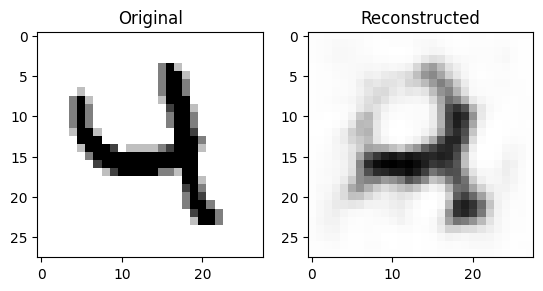

Loss = 0.04487831890583038


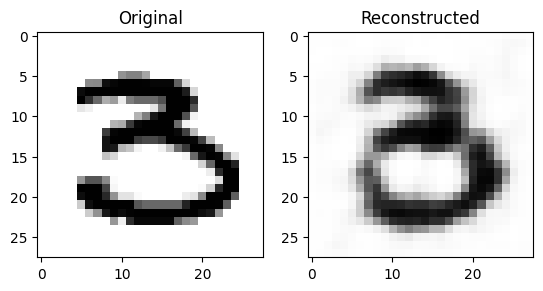

Loss = 0.02418542467057705


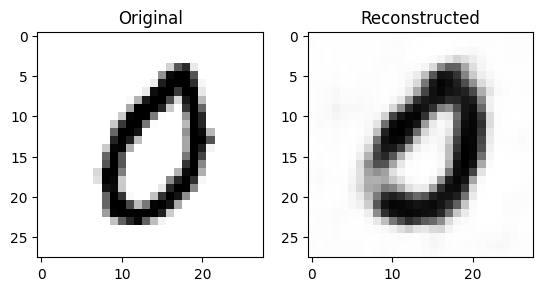

Loss = 0.036017827689647675


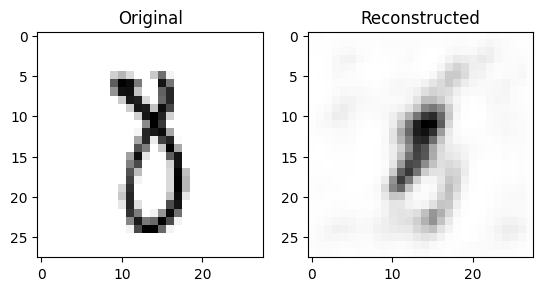

Loss = 0.03928668797016144


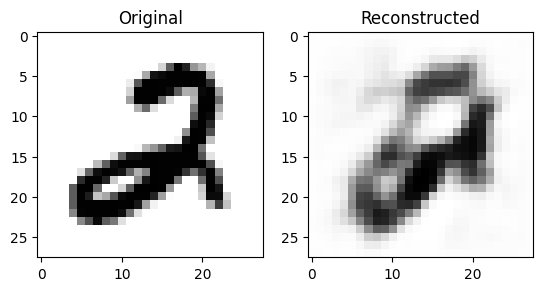

In [7]:
# Construct a VAE model and load the weights from the saved file:
print('Load network weights:')
model = FCNN_VAE()
model.load_state_dict(torch.load("vae_model.pth"))


import numpy as np
# (re)load the data:
print('Load the data.')
training_data, test_data, training_x, training_y, training_labels, test_x, test_y, test_labels = VAE.load_training_data()

print('Reconstruct images')
loss_fn = nn.MSELoss()
n_samples = 5
for sam in range(n_samples):
    sample_idx = torch.randint(len(training_x), size=(1,)).item()
    img = training_x[sample_idx]
    img = torch.reshape(img, (1,1,28,28))
    reconstr = model(img)
    loss = loss_fn(img, reconstr).item()
    print(f'Loss = {loss}')
    VAE.show_img_and_reconstr(img, reconstr)

5. Now we perform the same analysis for the variational auto-encoder as for the auto-encoder before. Let us first sample from a Gaussian distribution, and run the decoder. What do you observe?

C:\Users\gdecroon\AppData\Local\Temp\ipykernel_46940\1160925341.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,sam+1)


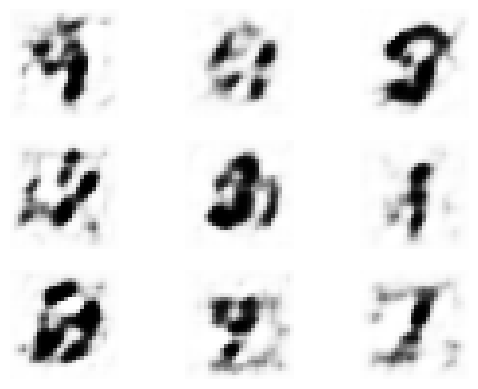

In [10]:
from matplotlib import pyplot as plt

n_hidden = 50
n_samples = 9

plt.figure()
plt.title('Random Samples from Latent Space')
for sam in range(n_samples):
    latent = torch.randn((1,n_hidden))
    reconstr = model.decoder(latent)
    plt.subplot(3,3,sam+1)
    plt.imshow(1-reconstr.detach().cpu().numpy().reshape((28,28)),  cmap='gray')
    plt.axis('off')
plt.show()

6. Finally, we analyze the latent space with t-SNE. Do so by running the cell below. What do you observe?

Running on the whole data set.
Performing t-SNE


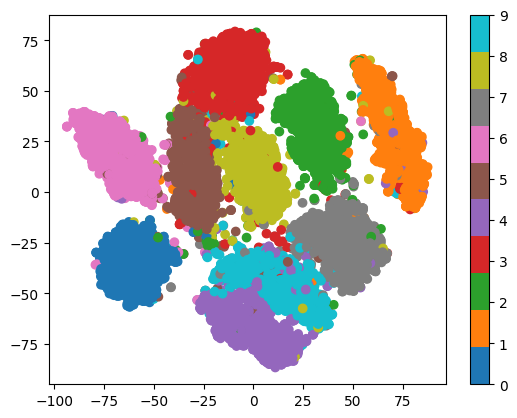

In [11]:
from sklearn.manifold import TSNE 
import numpy as np

# run the model on all training samples, storing the latent space activations:
print('Running on the whole data set.')
step = 5 # ok, not the whole data set : )
latents = torch.zeros((len(training_x)//step, n_hidden))
labels = np.zeros((len(training_x)//step,))
with torch.no_grad():
    for i in range(0,len(training_x),step):
        X = training_x[i]
        X = X.reshape((1,1,28,28))
        _ = model(X)
        latents[i//step] = model.latent
        labels[i//step] = training_labels[i]

# run t-SNE on the latent space:

# Move to CPU and convert to numpy
latent_np = latents.detach().cpu().numpy()

print('Performing t-SNE')
# Run t-SNE (reduce to 2D for visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_np)

# plot the 2d representation of the latent space: 
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="tab10")
plt.colorbar()
plt.show()

## Solutions

**<span style="color:red">Exercise 1: Implementing and training the VAE</span>**

1.  A major question when actually implementing the VAE is how to represent the standard deviation of the latent distribution. When representing the standard deviation directly by the hidden units, the function $\mathrm{log}(\frac{1}{\sigma_i^2})$ leads to problems, with `-inf` values. Hence, it is common to represent the standard deviation in the hidden layer with a log-var representation, i.e., $h_i = \mathrm{log}(\sigma_i^2)$ See the code below.


In [ ]:
import torch
from torch import nn
import VAE

class FCNN_VAE(nn.Module):
    def __init__(self, n_hidden = 50):
        super(FCNN_VAE, self).__init__()
        self.flatten = nn.Flatten()
        
        in_channel = 1
        out_channel = 16
        self.n_hidden = n_hidden
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=5, padding ='same') # bias = False
        self.act1 = nn.ReLU(inplace= True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear2 = nn.Linear(3136,n_hidden)
        self.linear5 = nn.Linear(n_hidden//2, 2304)
        self.act5 = nn.ReLU(inplace= True)
        self.resh = nn.Unflatten(1, (16, 12, 12))
        self.deconv = nn.ConvTranspose2d(out_channel, in_channel, kernel_size=6, stride = 2, padding_mode ='zeros')
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):

        # convolutional pipeline:
        
        # encoder:
        self.feature_maps = self.conv1(x)
        tmp = self.act1(self.feature_maps)
        tmp = self.maxpool1(tmp)
        tmp = torch.flatten(tmp, 1, -1)
        tmp = self.linear2(tmp)

        # latent space:
        self.latent = tmp
        
        # *****************************
        # TODO: fill in your code here:
        # *****************************
        
        self.mu = tmp[:,:self.n_hidden//2]
        self.logvar = tmp[:,self.n_hidden//2:]
        batch, dim = self.mu.shape
        var = torch.exp(self.logvar)
        std = torch.sqrt(var)
        eps = torch.randn_like(std)
        sample = self.mu + eps * std

        # decoder:
        tmp = self.linear5(sample)
        tmp = self.act5(tmp)
        tmp = torch.flatten(tmp, 1, -1)
        tmp = self.resh(tmp)
        logits = self.deconv(tmp)
        logits = self.sigmoid(logits)

        return logits

    def decoder(self, latent):

        # *****************************
        # TODO: fill in your code here:
        # *****************************
        self.mu = latent[:,:self.n_hidden//2]
        self.logvar = latent[:,self.n_hidden//2:]
        batch, dim = self.mu.shape
        var = torch.exp(self.logvar)
        std = torch.sqrt(var)
        eps = torch.randn_like(std)
        sample = self.mu + eps * std

        # decode the sample:
        tmp = self.linear5(sample)
        tmp = self.act5(tmp)
        tmp = torch.flatten(tmp, 1, -1)
        tmp = self.resh(tmp)
        logits = self.deconv(tmp)
        logits = self.sigmoid(logits)

        return logits

2-4. The $\beta$ parameter, which sometimes is not used, i.e., set to $\beta=1$, is actually very important in this case. When set to $\beta=0$, the neural network will correspond to a normal auto-encoder. However, when set to $\beta=1$, for this task it puts too much emphasis on the KL-divergence. This leads to an almost zero loss for the KL-divergence, but really bad reconstruction. We found $\beta=10^{-3}$ to work well for this task.

In [ ]:
def train_loop(training_x, training_y, batch_size, model, loss_fn, optimizer):
    
    size = len(training_x)
    
    # shuffle the indices to get random batches:
    inds = np.random.permutation(size)
    
    num_batches = size // batch_size

    rec_loss = np.zeros((num_batches,))
    kl_div_loss = np.zeros((num_batches,))

    for batch in range(num_batches):
        
        # Get the batch samples:
        inds_batch = inds[batch*batch_size:(batch+1)*batch_size]
        X = training_x[inds_batch]
        y = training_y[inds_batch]
        
        # Compute prediction and loss
        pred = model(X)
        latent = model.latent
        
        # *********************************************
        # TODO: extract the mean and standard deviation
        # *********************************************
        
        mu = model.mu
        logvar = model.logvar
        var = torch.exp(logvar)

        # *************************
        # TODO: Implement the loss:
        # *************************
        
        # reconstruction loss:
        reconstruction_loss = loss_fn(pred, y)
        # add the KL divergence loss:
        beta = 1e-3
        kl_div = -0.5 * torch.sum(1 + torch.log(var) - mu.pow(2) - var)
        loss = reconstruction_loss + beta * kl_div / batch_size
        rec_loss[batch] = reconstruction_loss.item()
        kl_div_loss[batch] = kl_div.item()

        # Backpropagation
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return np.mean(rec_loss), np.mean(kl_div_loss)

5. When trained well, sampling from the standard Gaussian distribution gives images that better resemble digits. Of course, this is because we forced this distribution on the latent space. It facilitates the sampling of "new" images. 

6. The classes are much better separated now in the 2D representation of the latent space. Sampling from the latent space forces the network to deal with "noise" in the latent space, better separating different digits.

The main lesson from this exercise is that the **goal of the VAE is to better regularize the latent space**.